In [1]:

import matplotlib
matplotlib.use('Agg')
import os
import datetime
import numpy as np
import dill as pickle
import random
import sys
import seaborn as sns
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import rcParams
from collections import OrderedDict
import math
from matplotlib.lines import Line2D
from pylab import rcParams
from collections import Counter
from itertools import combinations
#from datetime import datetime

from shutil import copyfile
rcParams['figure.figsize'] = 25, 10

np.random.seed(0)
random.seed(0)
now = datetime.datetime.now().strftime("%B_%d_%Y_%H_%M_%S")
workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)
from codes.experimentclasses.RigidEthanolPCA2 import RigidEthanolPCA2
from codes.otherfunctions.get_dictionaries import get_all_atoms_4
from codes.otherfunctions.get_grads import get_grads
from codes.otherfunctions.multirun import get_support_recovery_lambda
from codes.otherfunctions.multirun import get_lower_interesting_lambda
from codes.otherfunctions.multirun import get_coeffs_and_lambdas
from codes.otherfunctions.multirun import get_support
from codes.otherfunctions.multiplot import plot_support_2d
from codes.otherfunctions.multiplot import plot_reg_path_ax_lambdasearch
from codes.otherfunctions.multiplot import plot_gs_v_dgnorm
from codes.otherfunctions.multiplot import plot_dot_distributions
from codes.otherfunctions.multirun import get_cosines
from codes.flasso.Replicate import Replicate
from codes.otherfunctions.multirun import get_olsnorm_and_supportsbrute
from codes.otherfunctions.multiplot import highlight_cell

from codes.geometer.RiemannianManifold import RiemannianManifold
from codes.geometer.ShapeSpace import ShapeSpace
from codes.geometer.TangentBundle import TangentBundle


def get_grads(experiment, Mpca, Mangles, N, selected_points):
    dimnoise = experiment.dimnoise
    dim = experiment.dim
    cores = experiment.cores

    tangent_bases = Mpca.get_wlpca_tangent_sel(Mpca, selected_points, dimnoise)
    subM = RiemannianManifold(Mpca.data[selected_points], dim)
    subM.tb = TangentBundle(subM, tangent_bases)
    N.tangent_bundle = TangentBundle(N, np.swapaxes(N.geom.rmetric.Hvv[:,:dim,:],1,2))

    df_M = experiment.get_dF_js_idM(Mpca, N, subM.tb, N.tangent_bundle, selected_points, dimnoise)
    df_M2 = df_M / np.sum(np.linalg.norm(df_M, axis=1) ** 2, axis=0)**(0.5)
    dg_x = experiment.get_dx_g_full(Mangles.data[selected_points])

    W = ShapeSpace(experiment.positions, Mangles.data)
    dw = W.get_dw(cores, experiment.atoms3, experiment.natoms, selected_points)
    dg_w = experiment.project(np.swapaxes(dw, 1, 2),
                              experiment.project(dw, dg_x))

    dg_w_pca = np.asarray([np.matmul(experiment.projector, dg_w[j].transpose()).transpose() for j in range(len(selected_points))])
    dgw_norm = experiment.normalize(dg_w_pca)
    dg_M = experiment.project(subM.tb.tangent_bases, dgw_norm)
    return (df_M2, dg_M, dg_w, dg_w_pca, dgw_norm)

#set parameters
n = 10000 #number of data points to simulate
nsel = 10 #number of points to analyze with lasso
#itermax = 1000 #maximum iterations per lasso run
tol = 1e-14 #convergence criteria for lasso
#lambdas = np.asarray([0,.01,.1,1,10,100], dtype = np.float16)#lambda values for lasso
#lambdas = np.asarray(np.hstack([np.asarray([0]),np.logspace(-3,1,11)]), dtype = np.float16)
n_neighbors = 1000 #number of neighbors in megaman
m = 3 #number of embedding dimensions (diffusion maps)
#diffusion_time = 1. #diffusion time controls gaussian kernel radius per gradients paper
diffusion_time = 0.05 #(yuchia suggestion)
dim = 2 #manifold dimension
dimnoise = 2
natoms = 9
cores = 3 #number of cores for parallel processing
cor = 0.0 #correlation for noise
var = 0.00001 #variance scaler for noise
cor = 0.0 #correlation for noise
var = 0.00001 #variance scaler for noise
ii = np.asarray([0,0,0,0,1,1,1,2]) # atom adjacencies for dihedral angle computation
jj = np.asarray([1,2,3,4,5,6,7,8])

#run experiment
atoms4 = np.asarray([[6,1,0,4],[4,0,2,8],[7,6,5,1],[3,0,2,4]],dtype = int)
nreps = 1
lambda_max = 1
max_search = 30

folder = workingdirectory + '/Figures/rigidethanol/' + now + 'n' + str(n) + 'nsel' + str(nsel) + 'nreps' + str(nreps)
os.mkdir(folder)

#src = workingdirectory + '/codes/experiments/rigidethanol_110120_nsel100_nreps25_var0.py'
#filenamescript = folder + '/script.py'
#copyfile(src, filenamescript)


/Users/samsonkoelle/manifoldflasso_jmlr


In [2]:

new_MN = True
new_grad = True
savename = 'rigidethanol_120620_samgl_n100pallnrep1norm'
savefolder = 'rigidethanol'
loadfolder = 'rigidethanol'
loadname = 'rigidethanol_120620_samgl_n100pallnrep1norm'
if new_MN == True:
    experiment = RigidEthanolPCA2(dim, cor, var, ii, jj, cores, False, atoms4)
    experiment.M, experiment.Mpca, projector = experiment.generate_data(noise=False)
    experiment.q = m
    experiment.m = m
    experiment.dimnoise = dimnoise
    experiment.projector = projector
    experiment.Mpca.geom = experiment.Mpca.compute_geom(diffusion_time, n_neighbors)
    experiment.N = experiment.Mpca.get_embedding3(experiment.Mpca.geom, m, diffusion_time, dim)



In [3]:
experiment

In [4]:
atoms4,p = get_all_atoms_4(natoms)
experiment.p = p
experiment.atoms4 = atoms4
#experiment.itermax = itermax
experiment.tol = tol
experiment.dnoise = dim
experiment.nreps = nreps
experiment.nsel = nsel
experiment.folder = folder

replicates = {}
selected_points_save = np.zeros((nreps,nsel))

print('pre-gradient acquisition')
print(datetime.datetime.now())

pre-gradient acquisition
2020-12-14 18:33:20.340728


In [6]:

from codes.geometer.RiemannianManifold import RiemannianManifold
from codes.geometer.ShapeSpace import ShapeSpace
from codes.geometer.TangentBundle import TangentBundle


def get_grads(experiment, Mpca, Mangles, N, selected_points):
    dimnoise = experiment.dimnoise
    dim = experiment.dim
    cores = experiment.cores

    tangent_bases = Mpca.get_wlpca_tangent_sel(Mpca, selected_points, dimnoise)
    subM = RiemannianManifold(Mpca.data[selected_points], dim)
    subM.tb = TangentBundle(subM, tangent_bases)
    N.tangent_bundle = TangentBundle(N, np.swapaxes(N.geom.rmetric.Hvv[:,:dim,:],1,2))

    df_M = experiment.get_dF_js_idM(Mpca, N, subM.tb, N.tangent_bundle, selected_points, dimnoise)
    df_M2 = df_M / np.sum(np.linalg.norm(df_M, axis=1) ** 2, axis=0)**(0.5)
    dg_x = experiment.get_dx_g_full(Mangles.data[selected_points])

    W = ShapeSpace(experiment.positions, Mangles.data)
    dw = W.get_dw(cores, experiment.atoms3, experiment.natoms, selected_points)
    dg_w = experiment.project(np.swapaxes(dw, 1, 2),
                              experiment.project(dw, dg_x))

    dg_w_pca = np.asarray([np.matmul(experiment.projector, dg_w[j].transpose()).transpose() for j in range(len(selected_points))])
    dgw_norm = experiment.normalize(dg_w_pca)
    dg_M = experiment.project(subM.tb.tangent_bases, dgw_norm)
    return (df_M2, dg_M, dg_w, dg_w_pca, dgw_norm,tangent_bases)



In [7]:
i = 0 
selected_points = np.random.choice(list(range(n)),nsel,replace = False)
selected_points_save[i] = selected_points
replicates[i] = Replicate()
replicates[i].nsel = nsel
replicates[i].selected_points = selected_points
replicates[i].df_M,replicates[i].dg_M,replicates[i].dg_w ,replicates[i].dg_w_pca ,replicates[i].dgw_norm ,replicates[i].tangent_bases = get_grads(experiment, experiment.Mpca, experiment.M, experiment.N, selected_points)
replicates[i].dg_M = np.swapaxes(replicates[i].dg_M, 1,2)


In [8]:
#df_M_full - normalize(df_M_full)

In [11]:
dg = np.swapaxes(replicates[i].dgw_norm,1,2)
df_M_full = np.einsum('n d m, n b d -> n b m', replicates[i].df_M,replicates[i].tangent_bases)

In [12]:
replicates[i].df_M.shape

(10, 2, 3)

In [13]:
from codes.flasso.GradientGroupLasso import GradientGroupLasso

In [14]:
#replicate = replicates_small[0]
reg_l1s = [0.1065] #.105 has 4, .108 has 1
reg_l2 = [0.]
max_iter = 500
learning_rate = 1000.
tol = 1e-14
#replicate = replicates_small[0]
GGL = GradientGroupLasso(dg, df_M_full, reg_l1s, reg_l2, max_iter,learning_rate, tol, beta0_npm= None)

In [15]:
GGL.fit()

0
lr 1000.0
lr 500.0
lr 250.0
lr 125.0
lr 62.5
lr 31.25
lr 15.625
lr 7.8125
lr 3.90625
lr 1.953125
lr 0.9765625
lr 0.48828125
lr 0.244140625
lr 0.1220703125
lr 0.06103515625
1
lr 0.06103515625
2
lr 0.06103515625
3
lr 0.06103515625
4
lr 0.06103515625
5
lr 0.06103515625
6
lr 0.06103515625
7
lr 0.06103515625
8
lr 0.06103515625
9
lr 0.06103515625
10
lr 0.06103515625
11
lr 0.06103515625
12
lr 0.06103515625
13
lr 0.06103515625
14
lr 0.06103515625
15
lr 0.06103515625
16
lr 0.06103515625
17
lr 0.06103515625
18
lr 0.06103515625
19
lr 0.06103515625
20
lr 0.06103515625
21
lr 0.06103515625
22
lr 0.06103515625
23
lr 0.06103515625
24
lr 0.06103515625
25
lr 0.06103515625
26
lr 0.06103515625
27
lr 0.06103515625
28
lr 0.06103515625
29
lr 0.06103515625
30
lr 0.06103515625
31
lr 0.06103515625
32
lr 0.06103515625
33
lr 0.06103515625
34
lr 0.06103515625
35
lr 0.06103515625
36
lr 0.06103515625
37
lr 0.06103515625
38
lr 0.06103515625
39
lr 0.06103515625
40
lr 0.06103515625
41
lr 0.06103515625
42
lr 0.0610351

lr 0.06103515625
389
lr 0.06103515625
390
lr 0.06103515625
391
lr 0.06103515625
392
lr 0.06103515625
393
lr 0.06103515625
394
lr 0.06103515625
395
lr 0.06103515625
396
lr 0.06103515625
397
lr 0.06103515625
398
lr 0.06103515625
399
lr 0.06103515625
400
lr 0.06103515625
401
lr 0.06103515625
402
lr 0.06103515625
403
lr 0.06103515625
404
lr 0.06103515625
405
lr 0.06103515625
406
lr 0.06103515625
407
lr 0.06103515625
408
lr 0.06103515625
409
lr 0.06103515625
410
lr 0.06103515625
411
lr 0.06103515625
412
lr 0.06103515625
413
lr 0.06103515625
414
lr 0.06103515625
415
lr 0.06103515625
416
lr 0.06103515625
417
lr 0.06103515625
418
lr 0.06103515625
419
lr 0.06103515625
420
lr 0.06103515625
421
lr 0.06103515625
422
lr 0.06103515625
423
lr 0.06103515625
424
lr 0.06103515625
425
lr 0.06103515625
426
lr 0.06103515625
427
lr 0.06103515625
428
lr 0.06103515625
429
lr 0.06103515625
430
lr 0.06103515625
431
lr 0.06103515625
432
lr 0.06103515625
433
lr 0.06103515625
434
lr 0.06103515625
435
lr 0.06103515

In [16]:
np.where(np.linalg.norm(np.linalg.norm(GGL.fit_[-1]['beta'], axis=2), axis=0) !=0.)[0]

array([181, 187, 199, 360, 384, 565, 566, 570, 576, 588, 602, 612, 638,
       709, 715, 721, 722, 733, 734, 739, 740, 745])

In [17]:
#replicate = replicates_small[0]
reg_l1s = [0.2065] #.105 has 4, .108 has 1
reg_l2 = [0.]
max_iter = 500
learning_rate = 1000.
tol = 1e-16
#replicate = replicates_small[0]
GGL2 = GradientGroupLasso(dg, df_M_full, reg_l1s, reg_l2, max_iter,learning_rate, tol, beta0_npm= None)
GGL2.fit(beta0_npm = GGL.fit_[-1]['beta'])

0
lr 1000.0
lr 500.0
lr 250.0
lr 125.0
lr 62.5
lr 31.25
lr 15.625
lr 7.8125
lr 3.90625
lr 1.953125
lr 0.9765625
1
lr 0.9765625
lr 0.48828125
2
lr 0.48828125
lr 0.244140625
3
lr 0.244140625
4
lr 0.244140625
5
lr 0.244140625
6
lr 0.244140625
7
lr 0.244140625
8
lr 0.244140625
9
lr 0.244140625
10
lr 0.244140625
11
lr 0.244140625
12
lr 0.244140625
13
lr 0.244140625
14
lr 0.244140625
15
lr 0.244140625
16
lr 0.244140625
17
lr 0.244140625
18
lr 0.244140625
19
lr 0.244140625
20
lr 0.244140625
21
lr 0.244140625
22
lr 0.244140625
23
lr 0.244140625
24
lr 0.244140625
25
lr 0.244140625
26
lr 0.244140625
27
lr 0.244140625
28
lr 0.244140625
29
lr 0.244140625
30
lr 0.244140625
31
lr 0.244140625
32
lr 0.244140625
33
lr 0.244140625
34
lr 0.244140625
35
lr 0.244140625
36
lr 0.244140625
37
lr 0.244140625
38
lr 0.244140625
39
lr 0.244140625
40
lr 0.244140625
41
lr 0.244140625
42
lr 0.244140625
43
lr 0.244140625
44
lr 0.244140625
45
lr 0.244140625
46
lr 0.244140625
47
lr 0.244140625
48
lr 0.244140625
49
lr 0

lr 0.244140625
433
lr 0.244140625
434
lr 0.244140625
435
lr 0.244140625
436
lr 0.244140625
437
lr 0.244140625
438
lr 0.244140625
439
lr 0.244140625
440
lr 0.244140625
441
lr 0.244140625
442
lr 0.244140625
443
lr 0.244140625
444
lr 0.244140625
445
lr 0.244140625
446
lr 0.244140625
447
lr 0.244140625
448
lr 0.244140625
449
lr 0.244140625
450
lr 0.244140625
451
lr 0.244140625
452
lr 0.244140625
453
lr 0.244140625
454
lr 0.244140625
455
lr 0.244140625
456
lr 0.244140625
457
lr 0.244140625
458
lr 0.244140625
459
lr 0.244140625
460
lr 0.244140625
461
lr 0.244140625
462
lr 0.244140625
463
lr 0.244140625
464
lr 0.244140625
465
lr 0.244140625
466
lr 0.244140625
467
lr 0.244140625
468
lr 0.244140625
469
lr 0.244140625
470
lr 0.244140625
471
lr 0.244140625
472
lr 0.244140625
473
lr 0.244140625
474
lr 0.244140625
475
lr 0.244140625
476
lr 0.244140625
477
lr 0.244140625
478
lr 0.244140625
479
lr 0.244140625
480
lr 0.244140625
481
lr 0.244140625
482
lr 0.244140625
483
lr 0.244140625
484
lr 0.2441406

In [18]:
np.where(np.linalg.norm(np.linalg.norm(GGL2.fit_[-1]['beta'], axis=2), axis=0) !=0.)[0]

array([181, 187, 570, 715, 721, 733, 739])

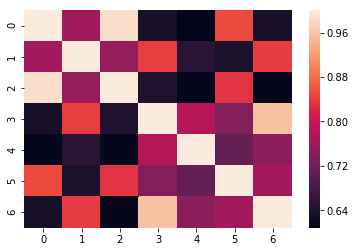

In [19]:
from codes.otherfunctions.multirun import get_cosines
cuz = get_cosines(np.swapaxes(dg[:,:,[181, 187, 570, 715, 721, 733, 739]], 1,2))
import seaborn as sns
%matplotlib inline
sns.heatmap(cuz)

In [22]:
nsel = 100 #number of points to analyze with lasso
i = 0 
selected_points = np.random.choice(list(range(n)),nsel,replace = False)
#selected_points_save[i] = selected_points
replicates[i] = Replicate()
replicates[i].nsel = nsel
replicates[i].selected_points = selected_points
replicates[i].df_M,replicates[i].dg_M,replicates[i].dg_w ,replicates[i].dg_w_pca ,replicates[i].dgw_norm ,replicates[i].tangent_bases = get_grads(experiment, experiment.Mpca, experiment.M, experiment.N, selected_points)
replicates[i].dg_M = np.swapaxes(replicates[i].dg_M, 1,2)


In [23]:
dg = np.swapaxes(replicates[i].dgw_norm,1,2)
df_M_full = np.einsum('n d m, n b d -> n b m', replicates[i].df_M,replicates[i].tangent_bases)

In [29]:
#replicate = replicates_small[0]
reg_l1s = [0.1065] #.105 has 4, .108 has 1
reg_l2 = [0.]
max_iter = 500
learning_rate = 1000.
tol = 1e-16
#replicate = replicates_small[0]
GGL3 = GradientGroupLasso(dg, df_M_full, reg_l1s, reg_l2, max_iter,learning_rate, tol, beta0_npm= None)
GGL3.fit()

0
lr 1000.0
lr 500.0
lr 250.0
lr 125.0
lr 62.5
lr 31.25
lr 15.625
lr 7.8125
lr 3.90625
lr 1.953125
1
lr 1.953125
2
lr 1.953125
3
lr 1.953125
4
lr 1.953125
5
lr 1.953125
6
lr 1.953125
7
lr 1.953125
8
lr 1.953125
9
lr 1.953125
10
lr 1.953125
11
lr 1.953125
12
lr 1.953125
13
lr 1.953125
14
lr 1.953125
15
lr 1.953125
16
lr 1.953125
17
lr 1.953125
18
lr 1.953125
19
lr 1.953125
20
lr 1.953125
21
lr 1.953125
22
lr 1.953125
23
lr 1.953125
24
lr 1.953125
25
lr 1.953125
26
lr 1.953125
27
lr 1.953125
28
lr 1.953125
29
lr 1.953125
30
lr 1.953125
31
lr 1.953125
32
lr 1.953125
33
lr 1.953125
34
lr 1.953125
35
lr 1.953125
36
lr 1.953125
37
lr 1.953125
38
lr 1.953125
39
lr 1.953125
40
lr 1.953125
41
lr 1.953125
42
lr 1.953125
43
lr 1.953125
44
lr 1.953125
45
lr 1.953125
46
lr 1.953125
47
lr 1.953125
48
lr 1.953125
49
lr 1.953125
50
lr 1.953125
51
lr 1.953125
52
lr 1.953125
53
lr 1.953125
54
lr 1.953125
55
lr 1.953125
56
lr 1.953125
57
lr 1.953125
58
lr 1.953125
59
lr 1.953125
60
lr 1.953125
61
lr 1.95

In [32]:
#do top features always still win if new features are introduced?
#if we have a bunch of the same data point, does that help?

In [33]:
np.where(np.linalg.norm(np.linalg.norm(GGL3.fit_[-1]['beta'], axis=2), axis=0) !=0.)[0]

array([199, 710, 734, 740, 746])

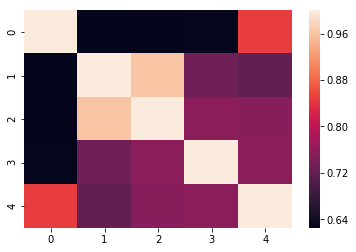

In [34]:
from codes.otherfunctions.multirun import get_cosines
cuz = get_cosines(np.swapaxes(dg[:,:,[199, 710, 734, 740, 746]], 1,2))
import seaborn as sns
%matplotlib inline
sns.heatmap(cuz)

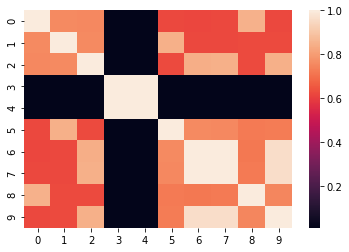

In [37]:
from codes.otherfunctions.multirun import get_cosines
cuz = get_cosines(np.swapaxes(dg[:,:,[181, 187, 199, 565, 566, 715, 721, 722, 733, 745]], 1,2))
import seaborn as sns
%matplotlib inline
sns.heatmap(cuz)

In [44]:
np.sum(dg[:,:,[181, 187, 199, 565, 566, 715, 721, 722, 733, 745]]**2, axis = 1).sum(axis = 0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [40]:
#so different from before...
reg_l1s = [0.1065] #.105 has 4, .108 has 1
reg_l2 = [0.]
max_iter = 500
learning_rate = 1000.
tol = 1e-16
#replicate = replicates_small[0]
GGL4 = GradientGroupLasso(dg, df_M_full, reg_l1s, reg_l2, max_iter,learning_rate, tol, beta0_npm= None)
GGL4.fit()

0
lr 1000.0
lr 500.0
lr 250.0
lr 125.0
lr 62.5
lr 31.25
lr 15.625
lr 7.8125
lr 3.90625
lr 1.953125
1
lr 1.953125
2
lr 1.953125
3
lr 1.953125
4
lr 1.953125
5
lr 1.953125
6
lr 1.953125
7
lr 1.953125
8
lr 1.953125
9
lr 1.953125
10
lr 1.953125
11
lr 1.953125
12
lr 1.953125
13
lr 1.953125
14
lr 1.953125
15
lr 1.953125
16
lr 1.953125
17
lr 1.953125
18
lr 1.953125
19
lr 1.953125
20
lr 1.953125
21
lr 1.953125
22
lr 1.953125
23
lr 1.953125
24
lr 1.953125
25
lr 1.953125
26
lr 1.953125
27
lr 1.953125
28
lr 1.953125
29
lr 1.953125
30
lr 1.953125
31
lr 1.953125
32
lr 1.953125
33
lr 1.953125
34
lr 1.953125
35
lr 1.953125
36
lr 1.953125
37
lr 1.953125
38
lr 1.953125
39
lr 1.953125
40
lr 1.953125
41
lr 1.953125
42
lr 1.953125
43
lr 1.953125
44
lr 1.953125
45
lr 1.953125
46
lr 1.953125
47
lr 1.953125
48
lr 1.953125
49
lr 1.953125
50
lr 1.953125
51
lr 1.953125
52
lr 1.953125
53
lr 1.953125
54
lr 1.953125
55
lr 1.953125
56
lr 1.953125
57
lr 1.953125
58
lr 1.953125
59
lr 1.953125
60
lr 1.953125
61
lr 1.95

In [45]:
np.where(np.linalg.norm(np.linalg.norm(GGL3.fit_[-1]['beta'], axis=2), axis=0) !=0.)[0]

array([199, 710, 734, 740, 746])

In [47]:
#try with iden
ts = np.zeros((100, 50,2))
for i in range(100):
    ts[i] = np.linalg.svd(df_M_full[i])[0][:,:2]

In [48]:
#replicate = replicates_small[0]
reg_l1s = [.91136] # [565, 566]...
#.9636,.9136 has 566 (1000 iter (390 converge)) #.9236 has array([ 31, 565, 566])
#.5136 1000 has many
reg_l2 = [0.]
max_iter = 500
learning_rate = 1000.
tol = 1e-16
#replicate = replicates_small[0] #GGL is .8136
GGL2 = GradientGroupLasso(dg, ts, reg_l1s, reg_l2, max_iter,learning_rate, tol, beta0_npm= None)

In [49]:
GGL2.fit()

0
lr 1000.0
lr 500.0
lr 250.0
lr 125.0
lr 62.5
lr 31.25
lr 15.625
lr 7.8125
lr 3.90625
lr 1.953125
lr 0.9765625
lr 0.48828125
1
lr 0.48828125
2
lr 0.48828125
3
lr 0.48828125
4
lr 0.48828125
5
lr 0.48828125
6
lr 0.48828125
7
lr 0.48828125
8
lr 0.48828125
9
lr 0.48828125
10
lr 0.48828125
11
lr 0.48828125
12
lr 0.48828125
13
lr 0.48828125
14
lr 0.48828125
15
lr 0.48828125
16
lr 0.48828125
17
lr 0.48828125
18
lr 0.48828125
19
lr 0.48828125
20
lr 0.48828125
21
lr 0.48828125
22
lr 0.48828125
23
lr 0.48828125
24
lr 0.48828125
25
lr 0.48828125
26
lr 0.48828125
27
lr 0.48828125
28
lr 0.48828125
29
lr 0.48828125
30
lr 0.48828125
31
lr 0.48828125
32
lr 0.48828125
33
lr 0.48828125
34
lr 0.48828125
35
lr 0.48828125
36
lr 0.48828125
37
lr 0.48828125
38
lr 0.48828125
39
lr 0.48828125
40
lr 0.48828125
41
lr 0.48828125
42
lr 0.48828125
43
lr 0.48828125
44
lr 0.48828125
45
lr 0.48828125
46
lr 0.48828125
47
lr 0.48828125
48
lr 0.48828125
49
lr 0.48828125
50
lr 0.48828125
51
lr 0.48828125
52
lr 0.48828125

lr 0.48828125
456
lr 0.48828125
457
lr 0.48828125
458
lr 0.48828125
459
lr 0.48828125
460
lr 0.48828125
461
lr 0.48828125
462
lr 0.48828125
463
lr 0.48828125
464
lr 0.48828125
465
lr 0.48828125
466
lr 0.48828125
467
lr 0.48828125
468
lr 0.48828125
469
lr 0.48828125
470
lr 0.48828125
471
lr 0.48828125
472
lr 0.48828125
473
lr 0.48828125
474
lr 0.48828125
475
lr 0.48828125
476
lr 0.48828125
477
lr 0.48828125
478
lr 0.48828125
479
lr 0.48828125
480
lr 0.48828125
481
lr 0.48828125
482
lr 0.48828125
483
lr 0.48828125
484
lr 0.48828125
485
lr 0.48828125
486
lr 0.48828125
487
lr 0.48828125
488
lr 0.48828125
489
lr 0.48828125
490
lr 0.48828125
491
lr 0.48828125
492
lr 0.48828125
493
lr 0.48828125
494
lr 0.48828125
495
lr 0.48828125
496
lr 0.48828125
497
lr 0.48828125
498
lr 0.48828125
499
lr 0.48828125
500
lr 0.48828125
501
lr 0.48828125
502
lr 0.48828125
503
lr 0.48828125
504
lr 0.48828125
505
lr 0.48828125
506
lr 0.48828125
507
lr 0.48828125
508
lr 0.48828125
509
lr 0.48828125
510
lr 0.48828

lr 0.48828125
912
lr 0.48828125
913
lr 0.48828125
914
lr 0.48828125
915
lr 0.48828125
916
lr 0.48828125
917
lr 0.48828125
918
lr 0.48828125
lr 0.244140625
919
lr 0.244140625
920
lr 0.244140625
921
lr 0.244140625
922
lr 0.244140625
923
lr 0.244140625
924
lr 0.244140625
925
lr 0.244140625
926
lr 0.244140625
927
lr 0.244140625
928
lr 0.244140625
929
lr 0.244140625
930
lr 0.244140625
931
lr 0.244140625
932
lr 0.244140625
933
lr 0.244140625
934
lr 0.244140625
935
lr 0.244140625
936
lr 0.244140625
937
lr 0.244140625
938
lr 0.244140625
939
lr 0.244140625
940
lr 0.244140625
941
lr 0.244140625
942
lr 0.244140625
943
lr 0.244140625
944
lr 0.244140625
945
lr 0.244140625
946
lr 0.244140625
947
lr 0.244140625
948
lr 0.244140625
949
lr 0.244140625
950
lr 0.244140625
951
lr 0.244140625
952
lr 0.244140625
953
lr 0.244140625
954
lr 0.244140625
lr 0.1220703125
lr 0.06103515625
955
lr 0.06103515625
lr 0.030517578125
lr 0.0152587890625
lr 0.00762939453125
lr 0.003814697265625
lr 0.0019073486328125
lr 0.00

lr 4.440892098500626e-13
1171
lr 4.440892098500626e-13
1172
lr 4.440892098500626e-13
1173
lr 4.440892098500626e-13
1174
lr 4.440892098500626e-13
1175
lr 4.440892098500626e-13
1176
lr 4.440892098500626e-13
1177
lr 4.440892098500626e-13
1178
lr 4.440892098500626e-13
1179
lr 4.440892098500626e-13
1180
lr 4.440892098500626e-13
1181
lr 4.440892098500626e-13
1182
lr 4.440892098500626e-13
1183
lr 4.440892098500626e-13
1184
lr 4.440892098500626e-13
1185
lr 4.440892098500626e-13
1186
lr 4.440892098500626e-13
1187
lr 4.440892098500626e-13
1188
lr 4.440892098500626e-13
1189
lr 4.440892098500626e-13
1190
lr 4.440892098500626e-13
1191
lr 4.440892098500626e-13
1192
lr 4.440892098500626e-13
1193
lr 4.440892098500626e-13
1194
lr 4.440892098500626e-13
1195
lr 4.440892098500626e-13
1196
lr 4.440892098500626e-13
1197
lr 4.440892098500626e-13
1198
lr 4.440892098500626e-13
1199
lr 4.440892098500626e-13
1200
lr 4.440892098500626e-13
1201
lr 4.440892098500626e-13
1202
lr 4.440892098500626e-13
1203
lr 4.44089

lr 2.220446049250313e-13
1444
lr 2.220446049250313e-13
1445
lr 2.220446049250313e-13
1446
lr 2.220446049250313e-13
1447
lr 2.220446049250313e-13
1448
lr 2.220446049250313e-13
1449
lr 2.220446049250313e-13
1450
lr 2.220446049250313e-13
1451
lr 2.220446049250313e-13
1452
lr 2.220446049250313e-13
1453
lr 2.220446049250313e-13
1454
lr 2.220446049250313e-13
1455
lr 2.220446049250313e-13
1456
lr 2.220446049250313e-13
1457
lr 2.220446049250313e-13
1458
lr 2.220446049250313e-13
1459
lr 2.220446049250313e-13
1460
lr 2.220446049250313e-13
1461
lr 2.220446049250313e-13
1462
lr 2.220446049250313e-13
1463
lr 2.220446049250313e-13
1464
lr 2.220446049250313e-13
1465
lr 2.220446049250313e-13
1466
lr 2.220446049250313e-13
1467
lr 2.220446049250313e-13
1468
lr 2.220446049250313e-13
1469
lr 2.220446049250313e-13
1470
lr 2.220446049250313e-13
1471
lr 2.220446049250313e-13
1472
lr 2.220446049250313e-13
1473
lr 2.220446049250313e-13
1474
lr 2.220446049250313e-13
1475
lr 2.220446049250313e-13
1476
lr 2.22044

lr 2.220446049250313e-13
1718
lr 2.220446049250313e-13
1719
lr 2.220446049250313e-13
1720
lr 2.220446049250313e-13
1721
lr 2.220446049250313e-13
1722
lr 2.220446049250313e-13
1723
lr 2.220446049250313e-13
1724
lr 2.220446049250313e-13
1725
lr 2.220446049250313e-13
1726
lr 2.220446049250313e-13
1727
lr 2.220446049250313e-13
1728
lr 2.220446049250313e-13
1729
lr 2.220446049250313e-13
1730
lr 2.220446049250313e-13
1731
lr 2.220446049250313e-13
1732
lr 2.220446049250313e-13
1733
lr 2.220446049250313e-13
1734
lr 2.220446049250313e-13
1735
lr 2.220446049250313e-13
1736
lr 2.220446049250313e-13
1737
lr 2.220446049250313e-13
1738
lr 2.220446049250313e-13
1739
lr 2.220446049250313e-13
1740
lr 2.220446049250313e-13
1741
lr 2.220446049250313e-13
1742
lr 2.220446049250313e-13
1743
lr 2.220446049250313e-13
1744
lr 2.220446049250313e-13
1745
lr 2.220446049250313e-13
1746
lr 2.220446049250313e-13
1747
lr 2.220446049250313e-13
1748
lr 2.220446049250313e-13
1749
lr 2.220446049250313e-13
1750
lr 2.22044

lr 2.220446049250313e-13
1992
lr 2.220446049250313e-13
1993
lr 2.220446049250313e-13
1994
lr 2.220446049250313e-13
1995
lr 2.220446049250313e-13
1996
lr 2.220446049250313e-13
1997
lr 2.220446049250313e-13
1998
lr 2.220446049250313e-13
1999
lr 2.220446049250313e-13
2000
lr 2.220446049250313e-13
2001
lr 2.220446049250313e-13
2002
lr 2.220446049250313e-13
2003
lr 2.220446049250313e-13
2004
lr 2.220446049250313e-13
2005
lr 2.220446049250313e-13
2006
lr 2.220446049250313e-13
2007
lr 2.220446049250313e-13
2008
lr 2.220446049250313e-13
2009
lr 2.220446049250313e-13
2010
lr 2.220446049250313e-13
2011
lr 2.220446049250313e-13
2012
lr 2.220446049250313e-13
2013
lr 2.220446049250313e-13
2014
lr 2.220446049250313e-13
2015
lr 2.220446049250313e-13
2016
lr 2.220446049250313e-13
2017
lr 2.220446049250313e-13
2018
lr 2.220446049250313e-13
2019
lr 2.220446049250313e-13
2020
lr 2.220446049250313e-13
2021
lr 2.220446049250313e-13
2022
lr 2.220446049250313e-13
2023
lr 2.220446049250313e-13
2024
lr 2.22044

lr 2.220446049250313e-13
2266
lr 2.220446049250313e-13
2267
lr 2.220446049250313e-13
2268
lr 2.220446049250313e-13
2269
lr 2.220446049250313e-13
2270
lr 2.220446049250313e-13
2271
lr 2.220446049250313e-13
2272
lr 2.220446049250313e-13
2273
lr 2.220446049250313e-13
2274
lr 2.220446049250313e-13
2275
lr 2.220446049250313e-13
2276
lr 2.220446049250313e-13
2277
lr 2.220446049250313e-13
2278
lr 2.220446049250313e-13
2279
lr 2.220446049250313e-13
2280
lr 2.220446049250313e-13
2281
lr 2.220446049250313e-13
2282
lr 2.220446049250313e-13
2283
lr 2.220446049250313e-13
2284
lr 2.220446049250313e-13
2285
lr 2.220446049250313e-13
2286
lr 2.220446049250313e-13
2287
lr 2.220446049250313e-13
2288
lr 2.220446049250313e-13
2289
lr 2.220446049250313e-13
2290
lr 2.220446049250313e-13
2291
lr 2.220446049250313e-13
2292
lr 2.220446049250313e-13
2293
lr 2.220446049250313e-13
2294
lr 2.220446049250313e-13
2295
lr 2.220446049250313e-13
2296
lr 2.220446049250313e-13
2297
lr 2.220446049250313e-13
2298
lr 2.22044

lr 2.220446049250313e-13
2540
lr 2.220446049250313e-13
2541
lr 2.220446049250313e-13
2542
lr 2.220446049250313e-13
2543
lr 2.220446049250313e-13
2544
lr 2.220446049250313e-13
2545
lr 2.220446049250313e-13
2546
lr 2.220446049250313e-13
2547
lr 2.220446049250313e-13
2548
lr 2.220446049250313e-13
2549
lr 2.220446049250313e-13
2550
lr 2.220446049250313e-13
2551
lr 2.220446049250313e-13
2552
lr 2.220446049250313e-13
2553
lr 2.220446049250313e-13
2554
lr 2.220446049250313e-13
2555
lr 2.220446049250313e-13
2556
lr 2.220446049250313e-13
2557
lr 2.220446049250313e-13
2558
lr 2.220446049250313e-13
2559
lr 2.220446049250313e-13
2560
lr 2.220446049250313e-13
2561
lr 2.220446049250313e-13
2562
lr 2.220446049250313e-13
2563
lr 2.220446049250313e-13
2564
lr 2.220446049250313e-13
2565
lr 2.220446049250313e-13
2566
lr 2.220446049250313e-13
2567
lr 2.220446049250313e-13
2568
lr 2.220446049250313e-13
2569
lr 2.220446049250313e-13
2570
lr 2.220446049250313e-13
2571
lr 2.220446049250313e-13
2572
lr 2.22044

lr 1.1102230246251565e-13
2810
lr 1.1102230246251565e-13
2811
lr 1.1102230246251565e-13
2812
lr 1.1102230246251565e-13
2813
lr 1.1102230246251565e-13
2814
lr 1.1102230246251565e-13
2815
lr 1.1102230246251565e-13
2816
lr 1.1102230246251565e-13
2817
lr 1.1102230246251565e-13
2818
lr 1.1102230246251565e-13
2819
lr 1.1102230246251565e-13
2820
lr 1.1102230246251565e-13
2821
lr 1.1102230246251565e-13
2822
lr 1.1102230246251565e-13
2823
lr 1.1102230246251565e-13
2824
lr 1.1102230246251565e-13
2825
lr 1.1102230246251565e-13
2826
lr 1.1102230246251565e-13
2827
lr 1.1102230246251565e-13
2828
lr 1.1102230246251565e-13
2829
lr 1.1102230246251565e-13
2830
lr 1.1102230246251565e-13
2831
lr 1.1102230246251565e-13
2832
lr 1.1102230246251565e-13
2833
lr 1.1102230246251565e-13
2834
lr 1.1102230246251565e-13
2835
lr 1.1102230246251565e-13
2836
lr 1.1102230246251565e-13
2837
lr 1.1102230246251565e-13
2838
lr 1.1102230246251565e-13
2839
lr 1.1102230246251565e-13
2840
lr 1.1102230246251565e-13
2841
lr 1.110

lr 1.1102230246251565e-13
3075
lr 1.1102230246251565e-13
3076
lr 1.1102230246251565e-13
3077
lr 1.1102230246251565e-13
3078
lr 1.1102230246251565e-13
3079
lr 1.1102230246251565e-13
3080
lr 1.1102230246251565e-13
3081
lr 1.1102230246251565e-13
3082
lr 1.1102230246251565e-13
3083
lr 1.1102230246251565e-13
3084
lr 1.1102230246251565e-13
3085
lr 1.1102230246251565e-13
3086
lr 1.1102230246251565e-13
3087
lr 1.1102230246251565e-13
3088
lr 1.1102230246251565e-13
3089
lr 1.1102230246251565e-13
3090
lr 1.1102230246251565e-13
3091
lr 1.1102230246251565e-13
3092
lr 1.1102230246251565e-13
3093
lr 1.1102230246251565e-13
3094
lr 1.1102230246251565e-13
3095
lr 1.1102230246251565e-13
3096
lr 1.1102230246251565e-13
3097
lr 1.1102230246251565e-13
3098
lr 1.1102230246251565e-13
3099
lr 1.1102230246251565e-13
3100
lr 1.1102230246251565e-13
3101
lr 1.1102230246251565e-13
3102
lr 1.1102230246251565e-13
3103
lr 1.1102230246251565e-13
3104
lr 1.1102230246251565e-13
3105
lr 1.1102230246251565e-13
3106
lr 1.110

lr 1.1102230246251565e-13
3340
lr 1.1102230246251565e-13
3341
lr 1.1102230246251565e-13
3342
lr 1.1102230246251565e-13
3343
lr 1.1102230246251565e-13
3344
lr 1.1102230246251565e-13
3345
lr 1.1102230246251565e-13
3346
lr 1.1102230246251565e-13
3347
lr 1.1102230246251565e-13
3348
lr 1.1102230246251565e-13
3349
lr 1.1102230246251565e-13
3350
lr 1.1102230246251565e-13
3351
lr 1.1102230246251565e-13
3352
lr 1.1102230246251565e-13
3353
lr 1.1102230246251565e-13
3354
lr 1.1102230246251565e-13
3355
lr 1.1102230246251565e-13
3356
lr 1.1102230246251565e-13
3357
lr 1.1102230246251565e-13
3358
lr 1.1102230246251565e-13
3359
lr 1.1102230246251565e-13
3360
lr 1.1102230246251565e-13
3361
lr 1.1102230246251565e-13
3362
lr 1.1102230246251565e-13
3363
lr 1.1102230246251565e-13
3364
lr 1.1102230246251565e-13
3365
lr 1.1102230246251565e-13
3366
lr 1.1102230246251565e-13
3367
lr 1.1102230246251565e-13
3368
lr 1.1102230246251565e-13
3369
lr 1.1102230246251565e-13
3370
lr 1.1102230246251565e-13
3371
lr 1.110

lr 1.1102230246251565e-13
3605
lr 1.1102230246251565e-13
3606
lr 1.1102230246251565e-13
3607
lr 1.1102230246251565e-13
3608
lr 1.1102230246251565e-13
3609
lr 1.1102230246251565e-13
3610
lr 1.1102230246251565e-13
3611
lr 1.1102230246251565e-13
3612
lr 1.1102230246251565e-13
3613
lr 1.1102230246251565e-13
3614
lr 1.1102230246251565e-13
3615
lr 1.1102230246251565e-13
3616
lr 1.1102230246251565e-13
3617
lr 1.1102230246251565e-13
3618
lr 1.1102230246251565e-13
3619
lr 1.1102230246251565e-13
3620
lr 1.1102230246251565e-13
3621
lr 1.1102230246251565e-13
3622
lr 1.1102230246251565e-13
3623
lr 1.1102230246251565e-13
3624
lr 1.1102230246251565e-13
3625
lr 1.1102230246251565e-13
3626
lr 1.1102230246251565e-13
3627
lr 1.1102230246251565e-13
3628
lr 1.1102230246251565e-13
3629
lr 1.1102230246251565e-13
3630
lr 1.1102230246251565e-13
3631
lr 1.1102230246251565e-13
3632
lr 1.1102230246251565e-13
3633
lr 1.1102230246251565e-13
3634
lr 1.1102230246251565e-13
3635
lr 1.1102230246251565e-13
3636
lr 1.110

lr 1.1102230246251565e-13
3870
lr 1.1102230246251565e-13
3871
lr 1.1102230246251565e-13
3872
lr 1.1102230246251565e-13
3873
lr 1.1102230246251565e-13
3874
lr 1.1102230246251565e-13
3875
lr 1.1102230246251565e-13
3876
lr 1.1102230246251565e-13
3877
lr 1.1102230246251565e-13
3878
lr 1.1102230246251565e-13
3879
lr 1.1102230246251565e-13
3880
lr 1.1102230246251565e-13
3881
lr 1.1102230246251565e-13
3882
lr 1.1102230246251565e-13
3883
lr 1.1102230246251565e-13
3884
lr 1.1102230246251565e-13
3885
lr 1.1102230246251565e-13
3886
lr 1.1102230246251565e-13
3887
lr 1.1102230246251565e-13
3888
lr 1.1102230246251565e-13
3889
lr 1.1102230246251565e-13
3890
lr 1.1102230246251565e-13
3891
lr 1.1102230246251565e-13
3892
lr 1.1102230246251565e-13
3893
lr 1.1102230246251565e-13
3894
lr 1.1102230246251565e-13
3895
lr 1.1102230246251565e-13
3896
lr 1.1102230246251565e-13
3897
lr 1.1102230246251565e-13
3898
lr 1.1102230246251565e-13
3899
lr 1.1102230246251565e-13
3900
lr 1.1102230246251565e-13
3901
lr 1.110

lr 5.551115123125783e-14
4136
lr 5.551115123125783e-14
4137
lr 5.551115123125783e-14
4138
lr 5.551115123125783e-14
4139
lr 5.551115123125783e-14
4140
lr 5.551115123125783e-14
4141
lr 5.551115123125783e-14
4142
lr 5.551115123125783e-14
4143
lr 5.551115123125783e-14
4144
lr 5.551115123125783e-14
4145
lr 5.551115123125783e-14
4146
lr 5.551115123125783e-14
4147
lr 5.551115123125783e-14
4148
lr 5.551115123125783e-14
4149
lr 5.551115123125783e-14
4150
lr 5.551115123125783e-14
4151
lr 5.551115123125783e-14
4152
lr 5.551115123125783e-14
4153
lr 5.551115123125783e-14
4154
lr 5.551115123125783e-14
4155
lr 5.551115123125783e-14
4156
lr 5.551115123125783e-14
4157
lr 5.551115123125783e-14
4158
lr 5.551115123125783e-14
4159
lr 5.551115123125783e-14
4160
lr 5.551115123125783e-14
4161
lr 5.551115123125783e-14
4162
lr 5.551115123125783e-14
4163
lr 5.551115123125783e-14
4164
lr 5.551115123125783e-14
4165
lr 5.551115123125783e-14
4166
lr 5.551115123125783e-14
4167
lr 5.551115123125783e-14
4168
lr 5.55111

lr 5.551115123125783e-14
4410
lr 5.551115123125783e-14
4411
lr 5.551115123125783e-14
4412
lr 5.551115123125783e-14
4413
lr 5.551115123125783e-14
4414
lr 5.551115123125783e-14
4415
lr 5.551115123125783e-14
4416
lr 5.551115123125783e-14
4417
lr 5.551115123125783e-14
4418
lr 5.551115123125783e-14
4419
lr 5.551115123125783e-14
4420
lr 5.551115123125783e-14
4421
lr 5.551115123125783e-14
4422
lr 5.551115123125783e-14
4423
lr 5.551115123125783e-14
4424
lr 5.551115123125783e-14
4425
lr 5.551115123125783e-14
4426
lr 5.551115123125783e-14
4427
lr 5.551115123125783e-14
4428
lr 5.551115123125783e-14
4429
lr 5.551115123125783e-14
4430
lr 5.551115123125783e-14
4431
lr 5.551115123125783e-14
4432
lr 5.551115123125783e-14
4433
lr 5.551115123125783e-14
4434
lr 5.551115123125783e-14
4435
lr 5.551115123125783e-14
4436
lr 5.551115123125783e-14
4437
lr 5.551115123125783e-14
4438
lr 5.551115123125783e-14
4439
lr 5.551115123125783e-14
4440
lr 5.551115123125783e-14
4441
lr 5.551115123125783e-14
4442
lr 5.55111

lr 2.7755575615628914e-14
4675
lr 2.7755575615628914e-14
4676
lr 2.7755575615628914e-14
4677
lr 2.7755575615628914e-14
4678
lr 2.7755575615628914e-14
4679
lr 2.7755575615628914e-14
4680
lr 2.7755575615628914e-14
4681
lr 2.7755575615628914e-14
4682
lr 2.7755575615628914e-14
4683
lr 2.7755575615628914e-14
4684
lr 2.7755575615628914e-14
4685
lr 2.7755575615628914e-14
4686
lr 2.7755575615628914e-14
4687
lr 2.7755575615628914e-14
4688
lr 2.7755575615628914e-14
4689
lr 2.7755575615628914e-14
4690
lr 2.7755575615628914e-14
4691
lr 2.7755575615628914e-14
4692
lr 2.7755575615628914e-14
4693
lr 2.7755575615628914e-14
4694
lr 2.7755575615628914e-14
4695
lr 2.7755575615628914e-14
4696
lr 2.7755575615628914e-14
4697
lr 2.7755575615628914e-14
4698
lr 2.7755575615628914e-14
4699
lr 2.7755575615628914e-14
4700
lr 2.7755575615628914e-14
4701
lr 2.7755575615628914e-14
4702
lr 2.7755575615628914e-14
4703
lr 2.7755575615628914e-14
4704
lr 2.7755575615628914e-14
4705
lr 2.7755575615628914e-14
4706
lr 2.775

lr 2.7755575615628914e-14
4940
lr 2.7755575615628914e-14
4941
lr 2.7755575615628914e-14
4942
lr 2.7755575615628914e-14
4943
lr 2.7755575615628914e-14
4944
lr 2.7755575615628914e-14
4945
lr 2.7755575615628914e-14
4946
lr 2.7755575615628914e-14
4947
lr 2.7755575615628914e-14
4948
lr 2.7755575615628914e-14
4949
lr 2.7755575615628914e-14
4950
lr 2.7755575615628914e-14
4951
lr 2.7755575615628914e-14
4952
lr 2.7755575615628914e-14
4953
lr 2.7755575615628914e-14
4954
lr 2.7755575615628914e-14
4955
lr 2.7755575615628914e-14
4956
lr 2.7755575615628914e-14
4957
lr 2.7755575615628914e-14
4958
lr 2.7755575615628914e-14
4959
lr 2.7755575615628914e-14
4960
lr 2.7755575615628914e-14
4961
lr 2.7755575615628914e-14
4962
lr 2.7755575615628914e-14
4963
lr 2.7755575615628914e-14
4964
lr 2.7755575615628914e-14
4965
lr 2.7755575615628914e-14
4966
lr 2.7755575615628914e-14
4967
lr 2.7755575615628914e-14
4968
lr 2.7755575615628914e-14
4969
lr 2.7755575615628914e-14
4970
lr 2.7755575615628914e-14
4971
lr 2.775

In [35]:
dg.shape

(100, 50, 756)

In [ ]:
#100... cool but slow.... evidence that run to convergence and no projection are both critical for success

In [21]:
#replicate = replicates_small[0]
reg_l1s = [0.1065] #.105 has 4, .108 has 1
reg_l2 = [0.]
max_iter = 500
learning_rate = 1000.
tol = 1e-14
#replicate = replicates_small[0]
GGL = GradientGroupLasso(dg, df_M_full, reg_l1s, reg_l2, max_iter,learning_rate, tol, beta0_npm= None)

In [22]:
GGL.fit()

0
lr 1000.0
lr 500.0
lr 250.0
lr 125.0
lr 62.5
lr 31.25
lr 15.625
lr 7.8125
lr 3.90625
lr 1.953125
1
lr 1.953125
2
lr 1.953125
3
lr 1.953125
4
lr 1.953125
5
lr 1.953125
6
lr 1.953125
7
lr 1.953125
8
lr 1.953125
9
lr 1.953125
10
lr 1.953125
11
lr 1.953125
12
lr 1.953125
13
lr 1.953125
14
lr 1.953125
15
lr 1.953125
16
lr 1.953125
17
lr 1.953125
18
lr 1.953125
19
lr 1.953125
20
lr 1.953125
21
lr 1.953125
22
lr 1.953125
23
lr 1.953125
24
lr 1.953125
25
lr 1.953125
26
lr 1.953125
27
lr 1.953125
28
lr 1.953125
29
lr 1.953125
30
lr 1.953125
31
lr 1.953125
32
lr 1.953125
33
lr 1.953125
34
lr 1.953125
35
lr 1.953125
36
lr 1.953125
37
lr 1.953125
38
lr 1.953125
39
lr 1.953125
40
lr 1.953125
41
lr 1.953125
42
lr 1.953125
43
lr 1.953125
44
lr 1.953125
45
lr 1.953125
46
lr 1.953125
47
lr 1.953125
48
lr 1.953125
49
lr 1.953125
50
lr 1.953125
51
lr 1.953125
52
lr 1.953125
53
lr 1.953125
54
lr 1.953125
55
lr 1.953125
56
lr 1.953125
57
lr 1.953125
58
lr 1.953125
59
lr 1.953125
60
lr 1.953125
61
lr 1.95

In [23]:
np.where(np.linalg.norm(np.linalg.norm(GGL.fit_[-1]['beta'], axis=2), axis=0) !=0.)[0]

array([181, 187, 710, 740, 745])

In [65]:
#replicate = replicates_small[0]
reg_l1s = [0.1236] #.1265 has 1... 0.1205 has 4 #0.1237 has 3 .1245, .124 has 1  #0.12375 is 2 (740, 745)
reg_l2 = [0.]
max_iter = 200
learning_rate = 1000.
tol = 1e-14
#replicate = replicates_small[0]
GGL = GradientGroupLasso(dg, df_M_full, reg_l1s, reg_l2, max_iter,learning_rate, tol, beta0_npm= None)

In [66]:
GGL.fit()

0
lr 1000.0
lr 500.0
lr 250.0
lr 125.0
lr 62.5
lr 31.25
lr 15.625
lr 7.8125
lr 3.90625
lr 1.953125
1
lr 1.953125
2
lr 1.953125
3
lr 1.953125
4
lr 1.953125
5
lr 1.953125
6
lr 1.953125
7
lr 1.953125
8
lr 1.953125
9
lr 1.953125
10
lr 1.953125
11
lr 1.953125
12
lr 1.953125
13
lr 1.953125
14
lr 1.953125
15
lr 1.953125
16
lr 1.953125
17
lr 1.953125
18
lr 1.953125
19
lr 1.953125
20
lr 1.953125
21
lr 1.953125
22
lr 1.953125
23
lr 1.953125
24
lr 1.953125
25
lr 1.953125
26
lr 1.953125
27
lr 1.953125
28
lr 1.953125
29
lr 1.953125
30
lr 1.953125
31
lr 1.953125
32
lr 1.953125
33
lr 1.953125
34
lr 1.953125
35
lr 1.953125
36
lr 1.953125
37
lr 1.953125
38
lr 1.953125
39
lr 1.953125
40
lr 1.953125
41
lr 1.953125
42
lr 1.953125
43
lr 1.953125
44
lr 1.953125
45
lr 1.953125
46
lr 1.953125
47
lr 1.953125
48
lr 1.953125
49
lr 1.953125
50
lr 1.953125
51
lr 1.953125
52
lr 1.953125
53
lr 1.953125
54
lr 1.953125
55
lr 1.953125
56
lr 1.953125
57
lr 1.953125
58
lr 1.953125
59
lr 1.953125
60
lr 1.953125
61
lr 1.95

In [67]:
np.where(np.linalg.norm(np.linalg.norm(GGL.fit_[-1]['beta'], axis=2), axis=0) !=0.)[0]

array([187, 740, 745])

In [68]:
atoms4[[187, 740,745]]

array([[2, 0, 5, 7],
       [8, 5, 4, 7],
       [6, 4, 7, 8]])

In [69]:
g1fast =  experiment.get_g_full_sub(experiment.M.data, np.asarray([8, 5, 4, 7]))
g2fast = experiment.get_g_full_sub(experiment.M.data, np.asarray([6, 4, 7, 8]))
g3fast = experiment.get_g_full_sub(experiment.M.data, np.asarray([2, 0, 5, 7])) #np.asarray([6, 4, 7, 8]))#np.asarray([2, 0, 6, 7]))

Text(0.5, 0, '3')

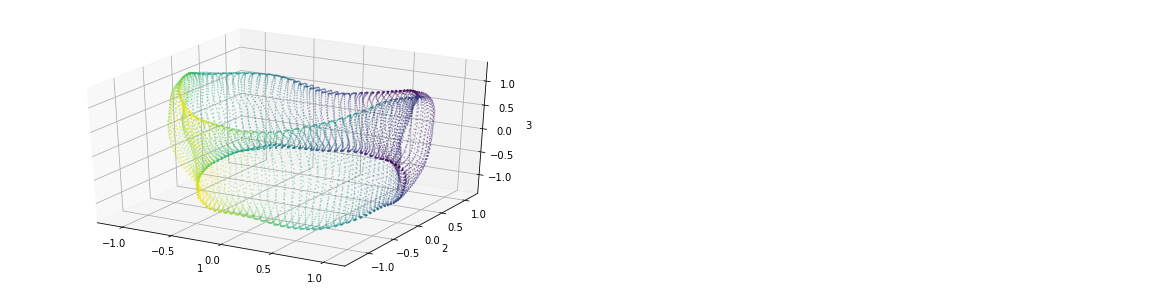

In [57]:
%matplotlib inline

data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

fig, axs = plt.subplots(2,1, figsize = (20,5))
data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5

axs[0].set_axis_off()
axs[1].set_axis_off()

ax = fig.add_subplot(1, 2, 1, projection='3d')

selected_points = list(range(10000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]
#fig = plt.figure(figsize=(15,10))
#ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(x, y, z, c=g1fast, s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
ax.set_xlabel('1')
ax.set_ylabel('2')
ax.set_zlabel('3')

Text(0.5, 0, '3')

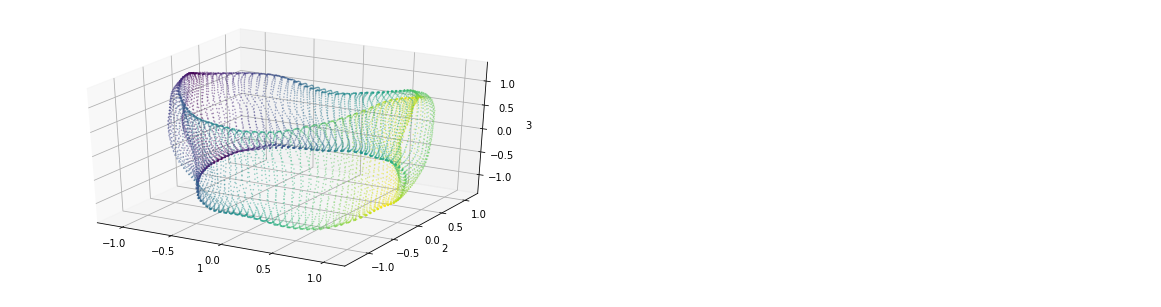

In [58]:
%matplotlib inline

data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

fig, axs = plt.subplots(2,1, figsize = (20,5))
data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5

axs[0].set_axis_off()
axs[1].set_axis_off()

ax = fig.add_subplot(1, 2, 1, projection='3d')

selected_points = list(range(10000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]
#fig = plt.figure(figsize=(15,10))
#ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(x, y, z, c=g2fast, s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
ax.set_xlabel('1')
ax.set_ylabel('2')
ax.set_zlabel('3')

Text(0.5, 0, '3')

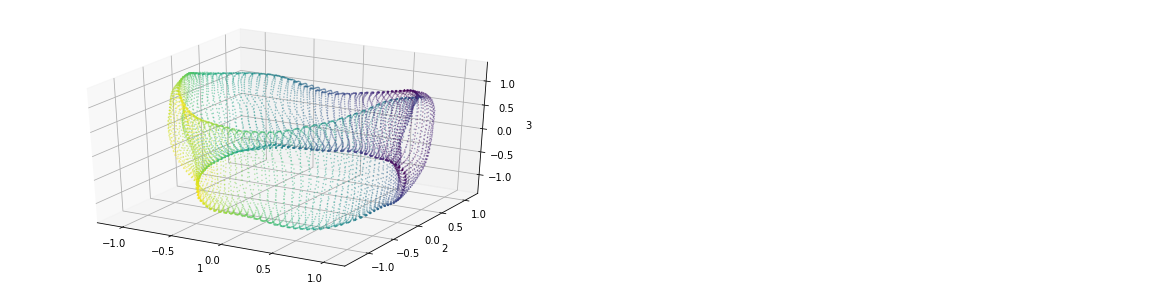

In [70]:
%matplotlib inline

data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

fig, axs = plt.subplots(2,1, figsize = (20,5))
data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5

axs[0].set_axis_off()
axs[1].set_axis_off()

ax = fig.add_subplot(1, 2, 1, projection='3d')

selected_points = list(range(10000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]
#fig = plt.figure(figsize=(15,10))
#ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(x, y, z, c=g3fast, s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
ax.set_xlabel('1')
ax.set_ylabel('2')
ax.set_zlabel('3')

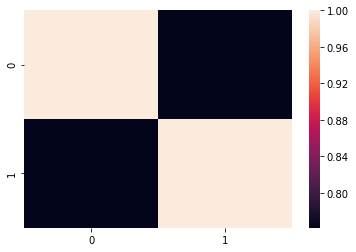

In [60]:
from codes.otherfunctions.multirun import get_cosines
cuz = get_cosines(np.swapaxes(dg[:,:,[740,745]], 1,2))
import seaborn as sns
%matplotlib inline
sns.heatmap(cuz)

In [61]:
    def normalize(jacobians):
        n = jacobians.shape[0]
        # could be p, or q
        p = jacobians.shape[2]
        d = jacobians.shape[1]

        gammas = np.sum(np.sum(jacobians ** 2, axis=1), axis=0) ** (.5)
        normed_jacobians = jacobians / gammas
        return(normed_jacobians)
        #print(normed.shape)
        #normed = np.swapaxes(normed, 1, 2)

In [64]:
dg - normalize(dg)

array([[[-6.93889390e-18, -6.93889390e-18,  0.00000000e+00, ...,
         -8.67361738e-19,  0.00000000e+00,  6.93889390e-18],
        [ 1.73472348e-18,  8.67361738e-19,  0.00000000e+00, ...,
         -4.33680869e-19,  0.00000000e+00, -3.46944695e-18],
        [ 8.67361738e-19,  1.73472348e-18,  0.00000000e+00, ...,
         -1.08420217e-19,  0.00000000e+00, -3.46944695e-18],
        ...,
        [-2.16840434e-19, -5.42101086e-20,  0.00000000e+00, ...,
          4.33680869e-19,  0.00000000e+00,  2.16840434e-19],
        [-3.46944695e-18,  1.73472348e-18,  0.00000000e+00, ...,
          3.46944695e-18,  0.00000000e+00, -1.73472348e-18],
        [ 1.73472348e-18,  8.67361738e-19,  0.00000000e+00, ...,
          8.67361738e-19,  0.00000000e+00, -8.67361738e-19]],

       [[-6.93889390e-18, -6.93889390e-18,  0.00000000e+00, ...,
         -1.73472348e-18,  0.00000000e+00,  3.46944695e-18],
        [ 8.67361738e-19,  8.67361738e-19,  0.00000000e+00, ...,
         -2.16840434e-19,  0.00000000e

In [79]:
ts = np.zeros((100, 50,2))
for i in range(100):
    ts[i] = np.linalg.svd(df_M_full[i])[0][:,:2]

In [81]:
ts

(100, 50, 2)

In [152]:
#replicate = replicates_small[0]
reg_l1s = [.91136] # [565, 566]...
#.9636,.9136 has 566 (1000 iter (390 converge)) #.9236 has array([ 31, 565, 566])
#.5136 1000 has many
reg_l2 = [0.]
max_iter = 5000
learning_rate = 1000.
tol = 1e-16
#replicate = replicates_small[0] #GGL is .8136
GGL2 = GradientGroupLasso(dg, ts, reg_l1s, reg_l2, max_iter,learning_rate, tol, beta0_npm= None)

In [ ]:
GGL2.fit(beta0_npm=GGL.fit_[-1]['beta'])

0
lr 1000.0
lr 500.0
lr 250.0
lr 125.0
lr 62.5
lr 31.25
1
lr 31.25
lr 15.625
lr 7.8125
lr 3.90625
2
lr 3.90625
lr 1.953125
3
lr 1.953125
4
lr 1.953125
5
lr 1.953125
6
lr 1.953125
7
lr 1.953125
8
lr 1.953125
9
lr 1.953125
10
lr 1.953125
11
lr 1.953125
12
lr 1.953125
13
lr 1.953125
14
lr 1.953125
15
lr 1.953125
16
lr 1.953125
17
lr 1.953125
18
lr 1.953125
19
lr 1.953125
20
lr 1.953125
21
lr 1.953125
22
lr 1.953125
23
lr 1.953125
24
lr 1.953125
25
lr 1.953125
26
lr 1.953125
27
lr 1.953125
28
lr 1.953125
29
lr 1.953125
30
lr 1.953125
31
lr 1.953125
32
lr 1.953125
33
lr 1.953125
34
lr 1.953125
35
lr 1.953125
36
lr 1.953125
37
lr 1.953125
38
lr 1.953125
39
lr 1.953125
40
lr 1.953125
41
lr 1.953125
42
lr 1.953125
43
lr 1.953125
44
lr 1.953125
45
lr 1.953125
46
lr 1.953125
47
lr 1.953125
48
lr 1.953125
49
lr 1.953125
50
lr 1.953125
51
lr 1.953125
52
lr 1.953125
53
lr 1.953125
54
lr 1.953125
55
lr 1.953125
56
lr 1.953125
57
lr 1.953125
58
lr 1.953125
59
lr 1.953125
60
lr 1.953125
61
lr 1.953125

lr 1.953125
515
lr 1.953125
516
lr 1.953125
517
lr 1.953125
518
lr 1.953125
519
lr 1.953125
520
lr 1.953125
521
lr 1.953125
522
lr 1.953125
523
lr 1.953125
524
lr 1.953125
525
lr 1.953125
526
lr 1.953125
527
lr 1.953125
528
lr 1.953125
529
lr 1.953125
530
lr 1.953125
531
lr 1.953125
532
lr 1.953125
533
lr 1.953125
534
lr 1.953125
535
lr 1.953125
536
lr 1.953125
537
lr 1.953125
538
lr 1.953125
539
lr 1.953125
540
lr 1.953125
541
lr 1.953125
542
lr 1.953125
543
lr 1.953125
544
lr 1.953125
545
lr 1.953125
546
lr 1.953125
547
lr 1.953125
548
lr 1.953125
549
lr 1.953125
550
lr 1.953125
551
lr 1.953125
552
lr 1.953125
553
lr 1.953125
554
lr 1.953125
555
lr 1.953125
556
lr 1.953125
557
lr 1.953125
558
lr 1.953125
559
lr 1.953125
560
lr 1.953125
561
lr 1.953125
562
lr 1.953125
563
lr 1.953125
564
lr 1.953125
565
lr 1.953125
566
lr 1.953125
567
lr 1.953125
568
lr 1.953125
569
lr 1.953125
570
lr 1.953125
571
lr 1.953125
572
lr 1.953125
573
lr 1.953125
574
lr 1.953125
575
lr 1.953125
576
lr 1.953

In [151]:
np.where(np.linalg.norm(np.linalg.norm(GGL2.fit_[-1]['beta'], axis=2), axis=0) !=0.)[0]

array([565, 566])

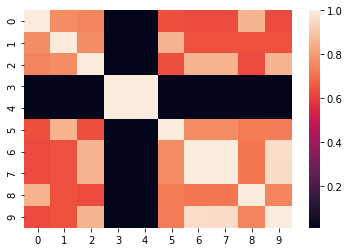

In [119]:
from codes.otherfunctions.multirun import get_cosines #.5136
cuz = get_cosines(np.swapaxes(dg[:,:,[181, 187, 199, 565, 566, 715, 721, 722, 733, 745]], 1,2))
import seaborn as sns
%matplotlib inline
sns.heatmap(cuz)

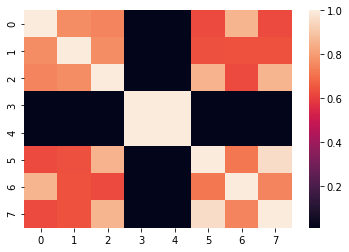

In [123]:
from codes.otherfunctions.multirun import get_cosines #.6136
cuz = get_cosines(np.swapaxes(dg[:,:,[181, 187, 199, 565, 566, 722, 733, 745]], 1,2))
import seaborn as sns
%matplotlib inline
sns.heatmap(cuz)

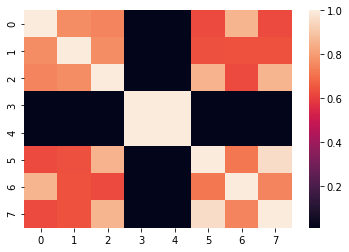

In [131]:
from codes.otherfunctions.multirun import get_cosines #.7136 1000 replicates nonconverged
cuz = get_cosines(np.swapaxes(dg[:,:,np.asarray([181, 187, 199, 565, 566, 722, 733, 745])], 1,2))
import seaborn as sns
%matplotlib inline
sns.heatmap(cuz)

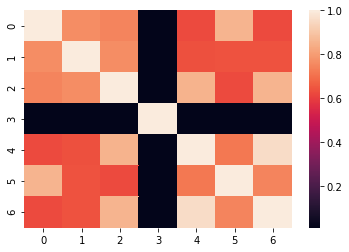

In [127]:
from codes.otherfunctions.multirun import get_cosines #.7136 4485 replicates converged
cuz = get_cosines(np.swapaxes(dg[:,:,np.asarray([181, 187, 199, 565, 722, 733, 745])], 1,2))
import seaborn as sns
%matplotlib inline
sns.heatmap(cuz)

In [ ]:
#try that one again
reg_l1s = [.7136] # [565, 566]...
#.9636,.9136 has 566 (1000 iter (390 converge)) #.9236 has array([ 31, 565, 566])
#.5136 1000 has many
reg_l2 = [0.]
max_iter = 5000
learning_rate = 1000.
tol = 1e-16
#replicate = replicates_small[0] #GGL is .8136
GGL71 = GradientGroupLasso(dg, ts, reg_l1s, reg_l2, max_iter,learning_rate, tol, beta0_npm= None)
GGL71.fit()

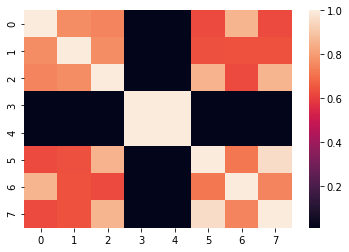

In [136]:
from codes.otherfunctions.multirun import get_cosines #.8136 4485 replicates converged
cuz = get_cosines(np.swapaxes(dg[:,:,np.asarray([181, 187, 199, 565, 566, 722, 733, 745])], 1,2))
import seaborn as sns
%matplotlib inline
sns.heatmap(cuz)

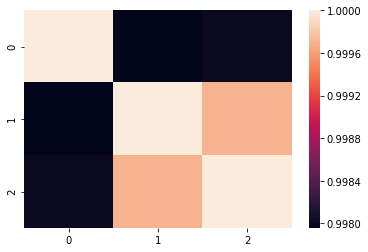

In [103]:
from codes.otherfunctions.multirun import get_cosines
cuz = get_cosines(np.swapaxes(dg[:,:,[ 31, 565, 566]], 1,2))
import seaborn as sns
%matplotlib inline
sns.heatmap(cuz)

In [13]:

# for i in range(nreps):

# with open(workingdirectory + '/untracked_data/embeddings/' + savefolder + '/' + savename + 'replicates.pkl' ,
#          'wb') as output:
#      pickle.dump(replicates, output, pickle.HIGHEST_PROTOCOL)


# selected_points_save = np.asarray(selected_points_save, dtype = int)
# gl_itermax = 500
# lambdas_start = [0.,.0005 * np.sqrt(nsel * p)]
# max_search = 15
# reg_l2 = 0.
# card = dim
# tol = 1e-14
# learning_rate = 100

# from pathos.multiprocessing import ProcessingPool as Pool
# from codes.flasso.GradientGroupLasso import batch_stream, get_sr_lambda_sam_parallel

# print('pre-gradient descent')
# print(datetime.datetime.now())
# cores = 16
# pcor = Pool(cores)
# results = pcor.map(lambda replicate: get_sr_lambda_sam_parallel(replicate, gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate),
#                 batch_stream(replicates))

#     # replicates[i].xtrain, replicates[i].groups = experiment.construct_X_js(replicates[i].dg_M)
#     # replicates[i].ytrain = experiment.construct_Y_js(replicates[i].df_M,dimnoise)
#     # replicates[i].coeff_dict = {}
#     # replicates[i].coeff_dict[0] = experiment.get_betas_spam2(replicates[i].xtrain, replicates[i].ytrain, replicates[i].groups, np.asarray([0]), nsel, experiment.m, itermax, tol)
#     # replicates[i].combined_norms = {}
#     # replicates[i].combined_norms[0] = np.linalg.norm(np.linalg.norm(replicates[i].coeff_dict[0][:, :, :, :], axis=2), axis=1)[0,:]
#     # replicates[i].higher_lambda,replicates[i].coeff_dict,replicates[i].combined_norms = get_support_recovery_lambda(experiment, replicates[i],  lambda_max, max_search,dim)
#     # replicates[i].lower_lambda,replicates[i].coeff_dict,replicates[i].combined_norms = get_lower_interesting_lambda(experiment, replicates[i],  lambda_max, max_search)
#     # #= experiment.get_betas_spam2(replicates[i].xtrain, replicates[i].ytrain, replicates[i].groups, lambdas, len(selected_points), n_embedding_coordinates, itermax, tol)



# with open(workingdirectory + '/untracked_data/embeddings/' + savefolder + '/' + savename + 'results.pkl' ,
#          'wb') as output:
#      pickle.dump(results, output, pickle.HIGHEST_PROTOCOL)

# print('done')
# print(datetime.datetime.now())
